In [1]:
import re
import matplotlib.pyplot as plt
import os
from torch.utils.tensorboard import SummaryWriter
from scipy.signal import savgol_filter
from tsmoothie.utils_func import sim_randomwalk
from tsmoothie.smoother import LowessSmoother
import numpy as np
import timm

/home/user/miniconda3/envs/yezey/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# 打开日志文件并读取内容
# paths =[ '/data1/YiZhenyu/Project/ssddet-main/results_seg/bce_unrefinebox',
#         '/data1/YiZhenyu/Project/ssddet-main/results_seg/bce_refinebox',
#         '/data1/YiZhenyu/Project/ssddet-main/results_seg/nbce_rbce_unrefinebox/a1_b0.1',
#         '/data1/YiZhenyu/Project/ssddet-main/results_seg/nbce_rbce_refinebox/a1_b0.1',
#         '/data1/YiZhenyu/Project/ssddet-main/results_seg/bce_clean_gt/polyp2']

# paths = ['/data1/YiZhenyu/Project/ssddet-main/results_seg/bce_clean_gt/polyp2',
#        '/data1/YiZhenyu/Project/ssddet-main/results_seg/nbce_rbce_refinebox/a1_b0.1_2']

# names = ['bce_unrefinebox','bce_refinebox','nbce_rbce_unrefinebox','nbce_rbce_refinebox']

# paths = ['/data1/YiZhenyu/Project/ssddet-main/results_seg_uniform_noise/bce_unrefinebox',
#          '/data1/YiZhenyu/Project/ssddet-main/results_seg_uniform_noise/bce_refinebox']


# paths = ['/data1/YiZhenyu/Project/ssddet-main/results_seg_uniform_noise/bce_unrefinebox',
#          '/data1/YiZhenyu/Project/ssddet-main/results_seg_uniform_noise/bce_refinebox',
#         '/data1/YiZhenyu/Project/ssddet-main/results_seg_uniform_noise/nbce_rbce_unrefinebox/a1_b0.1',
#         '/data1/YiZhenyu/Project/ssddet-main/results_seg_uniform_noise/nbce_rbce_refinebox/a1_b0.1',
#         '/data1/YiZhenyu/Project/ssddet-main/results_seg/bce_clean_gt/polyp1']

# paths = ['/data1/YiZhenyu/Project/ssddet-main/results_seg_uniform_noise_constant_lr/bce_refinebox',
#          '/data1/YiZhenyu/Project/ssddet-main/results_seg_uniform_noise_constant_lr/nbce_rbce_refinebox/a1_b0.1',
#          '/data1/YiZhenyu/Project/ssddet-main/results_seg_uniform_noise_constant_lr/bce_unrefinebox',
#          '/data1/YiZhenyu/Project/ssddet-main/results_seg_uniform_noise_constant_lr/nbce_rbce_unrefinebox/a1_b0.1',
#          '/data1/YiZhenyu/Project/ssddet-main/results_seg_uniform_noise_constant_lr/bce_clean_gt']

# paths = ['/data1/YiZhenyu/Project/ssddet-main/results_seg_uniform_noise_constant_lr/bce_clean_gt']


In [2]:
paths = [  
'/data1/YiZhenyu/Project/ssddet-main/results_singlescale/uniform/nbce_rbce_masksup_epoch15'
]
results = {}
for path in paths:
    for p in os.listdir(path):
        if p.endswith('.log'):
            path_log = p

    name = path.split('/')[7]
    writer_name = path.split('/')[5]
    with open(path+'/'+path_log, 'r') as file:
        log_lines = file.readlines()

    # 初始化存储结果的字典
    results[name] = []
    # 使用正则表达式来匹配包含 epoch 和 meandice 信息的行
    # checkpoint_pattern = r'Saving checkpoint at (\d+) epochs'
    meandice_pattern = r'meandice:([0-9.]+)'
    # CVC_300_pattern = r'CVC-300, dice: ([0-9.]+)'
    for line in log_lines:
        # 尝试匹配 epoch
        # epoch_match = re.search(checkpoint_pattern, line)
        # if epoch_match:
        #     epoch = int(epoch_match.group(1))
        #     results['epochs'].append(epoch)
        
        # 尝试匹配 meandice
        meandice_match = re.search(meandice_pattern, line)
        if meandice_match:
            meandice = float(meandice_match.group(1))
            results[name].append(meandice)

# # 打印提取的结果
# for epoch, meandice in zip(results['epochs'], results['meandice']):
#     print(f'Epoch {epoch}: Meandice {meandice}')

   nbce_rbce_masksup_epoch15 best:0.732


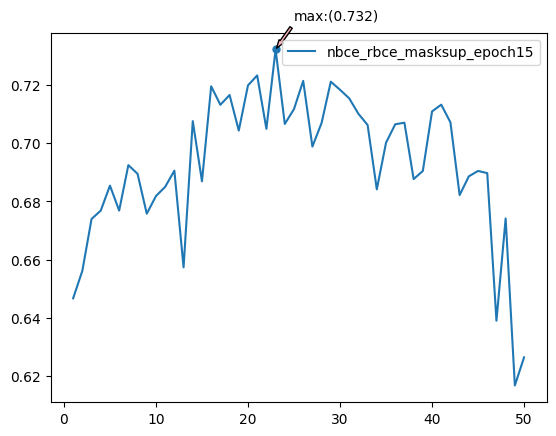

In [3]:
y_txt = 0.01
x_txt = 2
for key in results.keys():
    
    data  = results[key]
    if key == 'bce_clean_gt':
        data = data[:100]

    data = data[:76]
    x = np.arange(1,len(data)+1)

    max_id = np.argmax(data)  
    x_max,data_max = x[max_id],data[max_id]

    plt.plot(x,data,label=key)
    
    plt.scatter(x_max, data_max, s=25)

    plt.annotate(f'max:({data_max:.3f})', xy=(x_max, data_max), xytext=(x_max+x_txt, data_max+y_txt),
             arrowprops=dict(width=2,headwidth=4,headlength=6,facecolor='lightpink', shrink=0.05))
    y_txt = -y_txt
    x_txt = -x_txt
    print('  ',key,f'best:{data_max:.3f}')
    # plt.annotate(f'max:{data_max:.3f}', xy=(x_max, data_max), xytext=(x_max, data_max+0.01))

plt.legend()
plt.show()

In [53]:
save_path = 'curve'
os.makedirs(save_path,exist_ok=True)
writer = SummaryWriter(save_path)
steps = len(results[list(results.keys())[0]])
for step in range(steps):
    for key in results.keys():
        writer.add_scalars('dice',{key:results[key][step]},global_step=step)
    step+=1

In [17]:
path = '/data1/YiZhenyu/Project/ssddet-main/results_seg/nbce_rbce_refinebox/a1_b0.1_2/20231007_232819.log'
path ='/data1/YiZhenyu/Project/ssddet-main/results_seg/bce_clean_gt/polyp2/20231007_231251.log'
with open(path, 'r') as file:
    log_lines = file.readlines()
    results = []
    meandice_pattern = r'meandice:([0-9.]+)'
    for line in log_lines:
        meandice_match = re.search(meandice_pattern, line)
        if meandice_match:
            meandice = float(meandice_match.group(1))
            results.append(meandice)

test_mask + train_label + train_clean_label curves

In [9]:
paths = ['/data1/YiZhenyu/Project/ssddet-main/results_curve/nbce_rbce_unrefinebox/a1_b0.1']
results = {}
for path in paths:
    for p in os.listdir(path):
        if p.endswith('.log'):
            path_log = p

    name = path.split('/')[6]
    writer_name = path.split('/')[5]
    with open(path+'/'+path_log, 'r') as file:
        log_lines = file.readlines()

    # 初始化存储结果的字典
    results['test_mask'] = []
    results['train_label'] = []
    results['train_clean_label'] = []
    # 使用正则表达式来匹配包含 epoch 和 meandice 信息的行
    # checkpoint_pattern = r'Saving checkpoint at (\d+) epochs'
    meandice_pattern = r'meandice:([0-9.]+)'
    label_pattern = r' label_dice:([0-9.]+)'
    clean_label_pattern = r' clean_label_dice:([0-9.]+)'
    # CVC_300_pattern = r'CVC-300, dice: ([0-9.]+)'
    for line in log_lines:
        # 尝试匹配 epoch
        # epoch_match = re.search(checkpoint_pattern, line)
        # if epoch_match:
        #     epoch = int(epoch_match.group(1))
        #     results['epochs'].append(epoch)
        
        # 尝试匹配 meandice
        match = re.search(meandice_pattern, line)
        if match:
            dice = float(match.group(1))
            results['test_mask'].append(dice)

        match = re.search(label_pattern, line)
        if match:
            dice = float(match.group(1))
            results['train_label'].append(dice)

        match = re.search(clean_label_pattern, line)
        if match:
            dice = float(match.group(1))
            results['train_clean_label'].append(dice)

test_mask best: 0.6754597488121225
train_label best: 0.8139428437447689
train_clean_label best: 0.9014115636637371


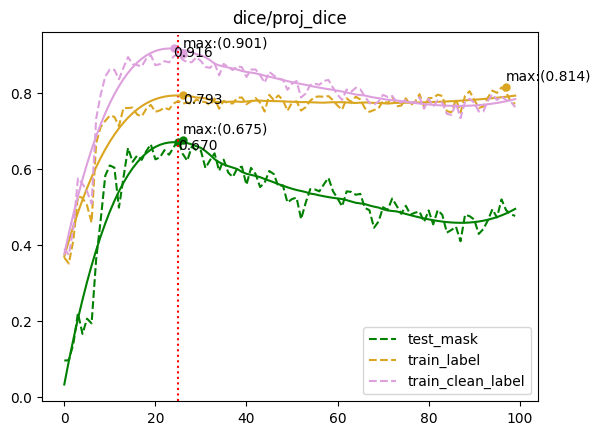

In [16]:
legends = []
smoother = LowessSmoother(smooth_fraction=0.1, iterations=1)
colors = ['g','goldenrod','plum']

for i,key in enumerate(results.keys()):
    data=results[key]
    x = np.arange(1,len(data)+1)
    max_id = np.argmax(data)  
    x_max,data_max = x[max_id],data[max_id]
    plt.plot(data,label=key,color=colors[i],linestyle='--')
    print(key,'best:',max(data))
    # smoother.smooth(results[key])
    # smooth_data = smoother.smooth_data[0]
    smooth_data = savgol_filter(data,53,3)
    plt.plot(smooth_data,color=colors[i])
    # low,up = smoother.get_intervals('prediction_interval')
    # plt.fill_between(range(len(smooth_data)), low[0], up[0], alpha=0.3) 
    plt.scatter(x_max, data_max,color=colors[i], s=25)
    plt.annotate(f'max:({data_max:.3f})', xy=(x_max, data_max), xytext=(x_max, data_max+0.02))

    max_id = np.argmax(smooth_data)  
    x_max,data_max = x[max_id],smooth_data[max_id]
    plt.scatter(x_max, data_max,color=colors[i], s=25)
    plt.annotate(f'{data_max:.3f}', xy=(x_max, data_max), xytext=(x_max, data_max-0.02))
    if key == 'test_mask':
        plt.axvline(x=x_max, ymin=0.0, ymax=0.99,linestyle=':',color='red')

plt.legend()
plt.title('dice/proj_dice')
plt.show()

In [85]:
a,b = torch.rand((2,10))
import numpy
c = b.numpy()
c.shape

(10,)

In [68]:
torch.rand(4).unsqueeze(-1).repeat(1,100).shape

torch.Size([4, 100])

In [89]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
path = '/data1/YiZhenyu/Project/polyp-segmentation/Polyp-PVT/dataset/TestDataset/total/masks/9.png'
m = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.uint8)

In [107]:
'''
Author: error: error: git config user.name & please set dead value or install git && error: git config user.email & please set dead value or install git & please set dead value or install git
Date: 2023-10-07 21:05:39
LastEditors: error: error: git config user.name & please set dead value or install git && error: git config user.email & please set dead value or install git & please set dead value or install git
LastEditTime: 2023-10-13 18:30:18
FilePath: /YiZhenyu/Project/tools/read_log_and_plot/read_log_and_plot.ipynb
Description: 这是默认设置,请设置`customMade`, 打开koroFileHeader查看配置 进行设置: https://github.com/OBKoro1/koro1FileHeader/wiki/%E9%85%8D%E7%BD%AE
'''
m = (m - m.min())/(m.max() - m.min())
m[m<0.5] = 0
m[m>0.5] = 1
contours, hierarchy = cv2.findContours(m.astype('uint8'), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
len(contours)
# if contours_len != 0:
#     # 遍历所有的轮廓，一个轮廓就是一个实例
#     for id, contour in enumerate(contours):
#         # 实例二值掩码
#         contour = np.flip(contour, axis=1)
#         segmentation = contour.ravel().tolist()
#         break
len(contours[1].ravel().tolist())
   

276

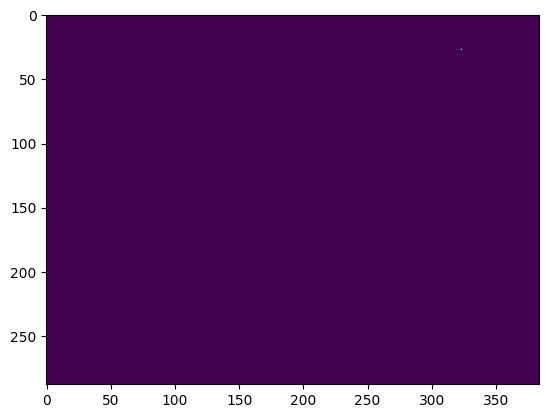

In [103]:
draw = np.zeros(m.shape)
cv2.drawContours(draw, contours[0], -1, (1,0,0), 1)
plt.imshow(draw)

In [ ]:
def genSeaCoco():
    # 读取要处理的文件列表
    data_txt = '/home/shicao/hjf/datasets/sea/01.txt'
    
    mask_list = []
    with open(data_txt, 'r') as f:
        # 读取文件中的第一行
        line = f.readline()
        # 读取文件中的所有行，并消除回车
        for line in f.readlines():
            line = line.strip('\n')
            mask_list.append(line)

    img_dir = '/home/shicao/hjf/datasets/sea/images'
    mask_dir = '/home/shicao/hjf/datasets/sea/processed_masks'

    image_id = 1
    annotation_id = 1

    coco_output = {
        "info": INFO,
        "licenses": LICENSES,
        "categories": CATEGORIES,
        "images": [],
        "annotations": []
    }

    # 依次处理每张图片
    print('处理总数', len(mask_list))
    for mask_name in mask_list:
        image_name = mask_name[: -3] + 'jpg'
        print('正在处理', image_name)
        image = Image.open(os.path.join(img_dir, image_name))
        image_info = pycococreatortools.create_image_info(image_id, os.path.basename(image_name), image.size)
        coco_output["images"].append(image_info)
        
        # 读取mask图像
        mask = np.array(cv2.imread(os.path.join(mask_dir, mask_name), cv2.IMREAD_GRAYSCALE)).astype(np.uint8)

        for class_id in range(8):
            binary_mask = copy.deepcopy(mask)  # 深拷贝
            binary_mask[binary_mask != class_id] = 0
            binary_mask[binary_mask == class_id] = 1
            category_info = {'id': class_id, 'is_crowd': 0}

            # 直接按颜色划分
            if class_id in [0, 1, 2, 3, 7]:
                annotation_info = pycococreatortools.create_annotation_info(
                    annotation_id, image_id, category_info, binary_mask, image.size, tolerance=2)
                # 只有当标签不为空时，掩码id才会自增
                if annotation_info is not None:
                    coco_output["annotations"].append(annotation_info)
                    annotation_id = annotation_id + 1
            else:
                # 寻找轮廓，为每个轮廓生成一个标注
                contours, hierarchy = cv2.findContours(binary_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
                contours_len = len(contours)
                if contours_len != 0:
                    # 遍历所有的轮廓，一个轮廓就是一个实例
                    for id, contour in enumerate(contours):
                        # 实例二值掩码
                        instance_binary_mask = np.zeros(binary_mask.shape)
                        polys = []
                        poly = np.array(contour, dtype=np.int32).reshape((len(contour), 2))
                        polys.append(poly)
                        # 多边形填充,生成二值图像，去生成掩码
                        cv2.fillPoly(instance_binary_mask, polys, 1)
                        # cv2.imwrite('/home/shicao/hjf/datasets/sea/{}.png'.format(id), (instance_binary_mask * 255).astype(np.uint8))

                        # 如果这个轮廓太小，则放弃
                        if np.count_nonzero(instance_binary_mask) < 20:
                            continue

                        # 为实例创建标注
                        annotation_info = pycococreatortools.create_annotation_info(
                            annotation_id, image_id, category_info, instance_binary_mask, image.size, tolerance=2)
                        # 只有当标签不为空时，掩码id才会自增
                        if annotation_info is not None:
                            coco_output["annotations"].append(annotation_info)
                            annotation_id = annotation_id + 1

        image_id = image_id + 1

    print('总的实例数', annotation_id)

    with open('/home/shicao/hjf/datasets/sea/annotation.json', 'w') as output_json_file:
        json.dump(coco_output, output_json_file, indent=2)



In [3]:
import sympy as sy

t = sy.symbols("t")
x = sy.Function("x")
y = sy.Function("y")

equation = x(t).diff(t,1)-3*x(t)+2*y(t)
equation2 = y(t).diff(t,1)-2*x(t)+y(t)

print(sy.dsolve([equation,equation2], [x(t),y(t)]))
sy.pprint(sy.dsolve([equation,equation2], [x(t),y(t)]))


[Eq(x(t), 2*C1*t*exp(t) + (C1 + 2*C2)*exp(t)), Eq(y(t), 2*C1*t*exp(t) + 2*C2*exp(t))]
⎡               t                t                 t         t⎤
⎣x(t) = 2⋅C₁⋅t⋅ℯ  + (C₁ + 2⋅C₂)⋅ℯ , y(t) = 2⋅C₁⋅t⋅ℯ  + 2⋅C₂⋅ℯ ⎦


In [1]:
import random
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import integrate

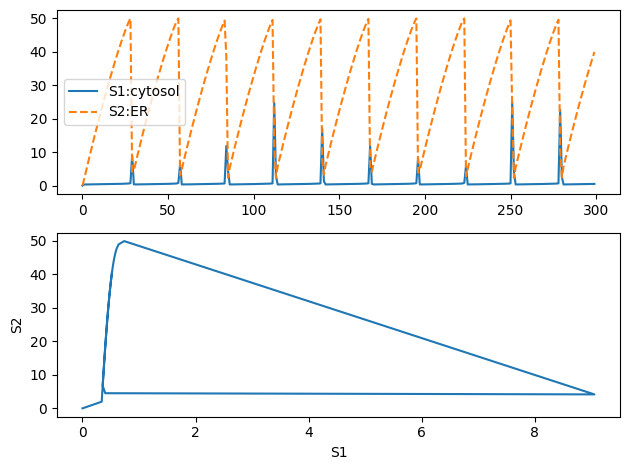

In [2]:

def derivative(X, t):
    x, y = X
    dotx = 1 + 0.01*y+ 5*y*x**4/(3.1**4+x**4) - 2*x - x
    doty = 2*x -  5*y*x**4/(3.1**4+x**4) - 0.01*y
    return np.array([dotx, doty])


Nt = 300
tmax = 1000.
t = np.linspace(0.,tmax, Nt)
x0 = 0.
y0 = 0.
X0 = [x0, y0]

res = integrate.odeint(derivative, X0, t)
x, y = res.T
fig, ax = plt.subplots(2,1)
ax[0].plot(x)
ax[0].plot(y,'--')
ax[0].legend(['S1:cytosol','S2:ER'])

ax[1].plot(x[:50],y[:50])
ax[1].set_xlabel('S1')
ax[1].set_ylabel('S2')
# plt.figure(figsize=(40,80))
plt.tight_layout()
plt.show()

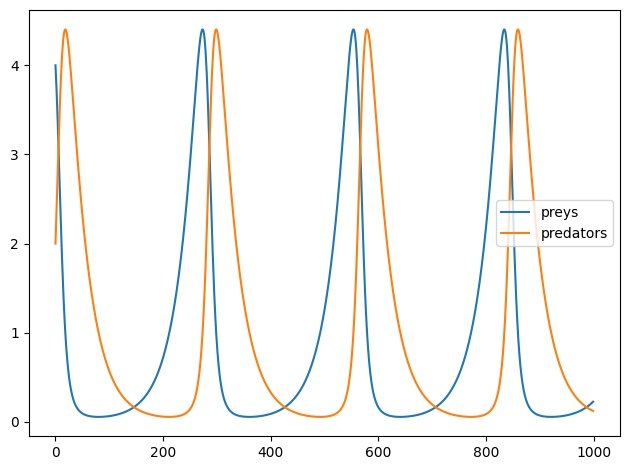

In [14]:

alpha = 1. #mortality rate due to predators
beta = 1.
delta = 1.
gamma = 1.
x0 = 4.
y0 = 2.

def derivative(X, t, alpha, beta, delta, gamma):
    x, y = X
    dotx = x * (alpha - beta * y)
    doty = y * (-delta + gamma * x)
    return np.array([dotx, doty])


Nt = 1000
tmax = 30.
t = np.linspace(0.,tmax, Nt)
X0 = [x0, y0]

res = integrate.odeint(derivative, X0, t, args = (alpha, beta, delta, gamma))
x, y = res.T

plt.plot(x)
plt.plot(y)
plt.legend(['preys','predators'])

# betas = np.arange(0.9, 1.4, 0.1)
# nums=np.random.random((10,len(betas)))
# colors = cm.rainbow(np.linspace(0, 1, nums.shape[0]))  # generate the colors for each data set

# fig, ax = plt.subplots(2,1)

# for beta, i in zip(betas, range(len(betas))):
#     res = integrate.odeint(derivative, X0, t, args = (alpha,beta, delta, gamma))
#     ax[0].plot(t, res[:,0], color = colors[i],  linestyle = '-', label = r"$\beta = $" + "{0:.2f}".format(beta))
#     ax[1].plot(t, res[:,1], color = colors[i], linestyle = '-', label = r" $\beta = $" + "{0:.2f}".format(beta))
#     ax[0].legend()
#     ax[1].legend()

# ax[0].grid()
# ax[1].grid()
# ax[0].set_xlabel('Time t, [days]')
# ax[0].set_ylabel('preys')
# ax[1].set_xlabel('Time t, [days]')
# ax[1].set_ylabel('predators')

plt.tight_layout()
plt.show()

In [11]:
import torch
torch.rand((3,7)).mean(dim=0)

tensor([0.4030, 0.7635, 0.5360, 0.5181, 0.6049, 0.2825, 0.5129])

In [44]:
a = torch.rand((3,2,4))
box=[torch.ones((3,2,4)),a]
[_.permute(1,0,2)for _ in box][1]

tensor([[[0.1416, 0.1683, 0.8608, 0.5043],
         [0.8616, 0.0966, 0.2963, 0.9161],
         [0.3771, 0.1942, 0.7488, 0.9244]],

        [[0.5183, 0.0889, 0.8764, 0.3918],
         [0.9602, 0.9093, 0.7981, 0.7019],
         [0.9858, 0.2475, 0.9086, 0.1497]]])

In [45]:
a

tensor([[[0.1416, 0.1683, 0.8608, 0.5043],
         [0.5183, 0.0889, 0.8764, 0.3918]],

        [[0.8616, 0.0966, 0.2963, 0.9161],
         [0.9602, 0.9093, 0.7981, 0.7019]],

        [[0.3771, 0.1942, 0.7488, 0.9244],
         [0.9858, 0.2475, 0.9086, 0.1497]]])

In [14]:
loss = dict()
loss.update({'sd':1})
loss

{'sd': 1}

In [15]:
loss.update({'sd':2})

In [7]:
import torch
import numpy as np
a = torch.tensor([1, 2, 3.], requires_grad=True)
a.detach().numpy()

array([1., 2., 3.], dtype=float32)

In [13]:
np.concatenate([np.arange(5),np.arange(5)]).reshape(2,-1)

array([], shape=(0, 5), dtype=int64)

In [17]:
b = torch.tensor([1,2,2]).data
a*b

tensor([1., 4., 6.], grad_fn=<MulBackward0>)